### Load Library

In [72]:
import pandas as pd
import numpy as np

from string import punctuation, ascii_lowercase, digits
from nltk.stem.snowball import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor

from datasets import load_dataset
from sklearn.model_selection import train_test_split

import re

import fasttext
import tempfile
import os

from sklearn.metrics import classification_report
import itertools


### Import Dataset

In [2]:
# Load the Yahoo! Answers Topic Classification dataset
dataset = load_dataset("yahoo_answers_topics")

train = dataset['train'].to_pandas()
train = train.drop(columns='id')

## Data Wrangling

### Remove special characters and punctuations

In [3]:
stopwordsSet = set(stopwords.words("english"))

# Create translation table for character filtering once
CHAR_MAP = str.maketrans('', '', punctuation)
VALID_CHARS = set(ascii_lowercase + digits + ' ')

# Compile regex pattern for multiple spaces
SPACE_PATTERN = re.compile(r'\s+')

@lru_cache(maxsize=200000)
def clean_text(content):
    """
    Clean text by converting to lowercase, removing punctuation and stopwords.
    Uses translation tables and caching for better performance.
    """
    # Convert to lowercase
    content = content.lower()
    
    # Remove punctuation using translation table
    content = content.translate(CHAR_MAP)
    
    # Keep only valid characters (faster than checking each character)
    content = ''.join(c for c in content if c in VALID_CHARS)
    
    # Replace multiple spaces with single space and split
    words = SPACE_PATTERN.sub(' ', content).split()
    
    # Filter stopwords
    return ' '.join(w for w in words if w not in stopwordsSet)

def batch_clean_texts(texts, batch_size=20000):
    """
    Clean multiple texts in parallel using batches.
    """
    # Split texts into batches
    batches = np.array_split(texts, max(1, len(texts) // batch_size))
    
    # Process batches in parallel
    with ThreadPoolExecutor() as executor:
        processed_batches = list(executor.map(
            lambda batch: [clean_text(str(text)) for text in batch],
            batches
        ))
    
    # Flatten results
    return [text for batch in processed_batches for text in batch]


In [4]:
train.question_title = batch_clean_texts(train.question_title.values)
train.question_content = batch_clean_texts(train.question_content.values)
train.best_answer = batch_clean_texts(train.best_answer.values)

In [5]:
# Example of website rows
# pd.set_option('display.max_colwidth', None)
selected_rows = train.iloc[6:8]
selected_rows

,topic,question_title,question_content,best_answer
6,1,people blush embarrassed,people blush embarrassed,ask yahoonhttpaskyahoocomask20040113htmlnblush...
7,7,lin qingxia aka brigitte lin beautiful woman c...,according stephen chow httpwwwhkentreviewcom20...,well everyone different definition beauty like...


In [6]:
# Example of mathmatical formula rows
selected_math_rows = train.iloc[15:16]
selected_math_rows[['best_answer']]

,best_answer
15,imaginary numbers numbers squared equal negati...


In [7]:
train

,topic,question_title,question_content,best_answer
0,4,doesnt optical mouse work glass table,even surfaces,optical mice use led camera rapidly capture im...
1,5,best offroad motorcycle trail,longdistance trail throughout ca,hear mojave road amazingbr nsearch online
2,2,trans fat reduce,heard tras fat bad body find daily food,trans fats occur manufactured foods process pa...
3,6,many planes fedex,heard largest airline world,according wwwfedexcom web sitenair fleetbr n b...
4,6,san francisco bay area make sense rent buy,prices rent price buying make sense mostly ren...,renting vs buying depends goals br ngenerally ...
...,...,...,...,...
1399995,2,ads tv yoko etc regarding height increase use,,increased height 2 feet afterwards yesnnof cou...
1399996,6,ways sell video games,like want sell video games sell,ebay electronic boutique babbages flea markets
1399997,2,normal nots breast boobs,,normal long cancerous breasts examined every 6...
1399998,0,speak hindi,write,main hindi bol sakti hoonkahiye


### Visualize frequent words

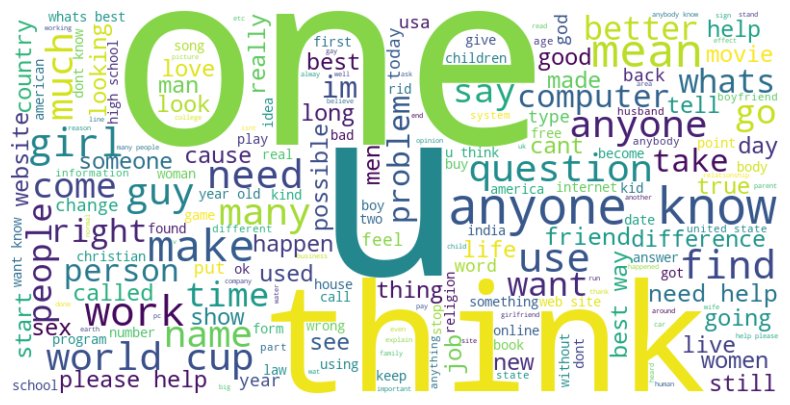

In [8]:
# Words in question title
question_titles = " ".join(s for s in train.question_title)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_titles)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

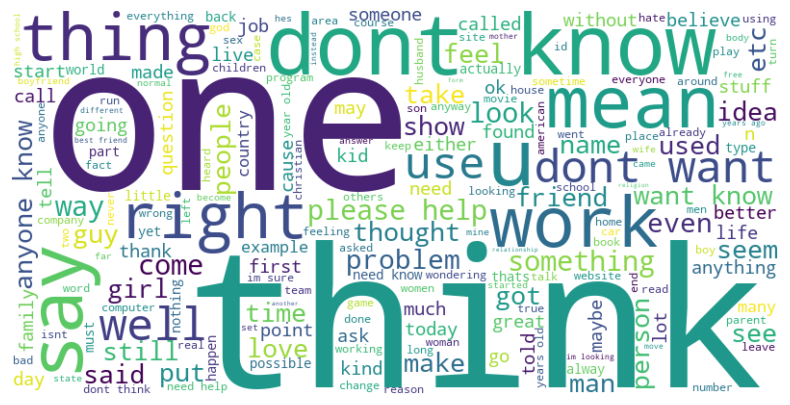

In [9]:
# Words in question content
question_contents = " ".join(s for s in train.question_content)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_contents)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

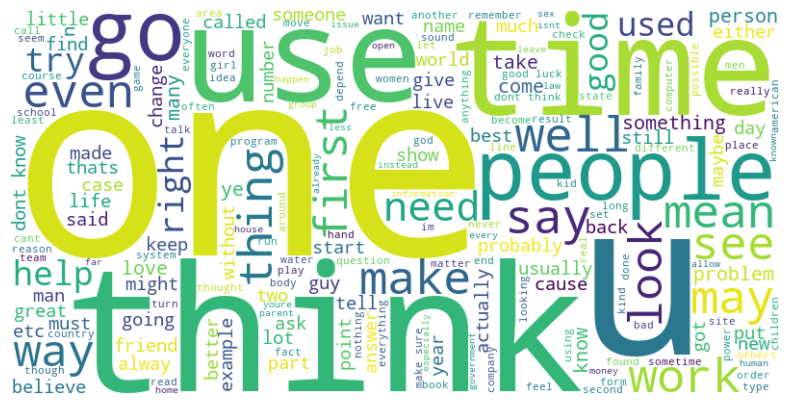

In [10]:
# Sample 20% of the words in answers
sample_answers = " ".join(s for s in train.best_answer.sample(frac=0.2, random_state=42))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sample_answers)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
# Create a topic mapping of label and name
topic_mapping = {
    0: "Society & Culture",
    1: "Science & Mathematics",
    2: "Health",
    3: "Education & Reference",
    4: "Computers & Internet",
    5: "Sports",
    6: "Business & Finance",
    7: "Entertainment & Music",
    8: "Family & Relationships",
    9: "Politics & Government"
}

train['topic_name'] = train['topic'].map(topic_mapping)

In [12]:
# check number of records for each topic
topic_counts = train['topic_name'].value_counts()
topic_counts

topic_name
Computers & Internet      140000
Sports                    140000
Health                    140000
Business & Finance        140000
Science & Mathematics     140000
Entertainment & Music     140000
Education & Reference     140000
Family & Relationships    140000
Politics & Government     140000
Society & Culture         140000
Name: count, dtype: int64

### Check Empty Values and Combine Columns

In [13]:
# check NaN
train_copy = train.copy()
train_copy.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = train_copy.isna().sum()
nan_counts

topic                    0
question_title        4183
question_content    635515
best_answer          31120
topic_name               0
dtype: int64

In [14]:
# Combine Question title and question content together
combine = train.copy()
combine['question'] = combine['question_title'] + ' ' + combine['question_content']
combine = combine.drop(columns=['question_title', 'question_content'])

In [15]:
combine.head()

,topic,best_answer,topic_name,question
0,4,optical mice use led camera rapidly capture im...,Computers & Internet,doesnt optical mouse work glass table even sur...
1,5,hear mojave road amazingbr nsearch online,Sports,best offroad motorcycle trail longdistance tra...
2,2,trans fats occur manufactured foods process pa...,Health,trans fat reduce heard tras fat bad body find ...
3,6,according wwwfedexcom web sitenair fleetbr n b...,Business & Finance,many planes fedex heard largest airline world
4,6,renting vs buying depends goals br ngenerally ...,Business & Finance,san francisco bay area make sense rent buy pri...


In [16]:
combine.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = combine.isna().sum()
nan_counts

topic              0
best_answer    31120
topic_name         0
question         328
dtype: int64

In [17]:
# drop all NaNs from train dataset
train_clean = combine.dropna().copy()
train_clean.replace(r'^\s*$', pd.NA, regex=True, inplace=True)
nan_counts = train_clean.isna().sum()
nan_counts

topic          0
best_answer    0
topic_name     0
question       0
dtype: int64

In [18]:
train_clean.shape

(1368590, 4)

### Check Duplicates

In [19]:
duplicate_count = train_clean.duplicated(subset=['topic', 'question', 'best_answer']).sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 297


In [20]:
# drop duplicates
train_clean_no_duplicates = train_clean.drop_duplicates(subset=['topic', 'question', 'best_answer']).reset_index(drop=True)

In [21]:
len(train_clean_no_duplicates)

1368293

In [22]:
# check number of records for each topic
topic_counts = train_clean_no_duplicates['topic_name'].value_counts()
topic_counts = pd.DataFrame(topic_counts)

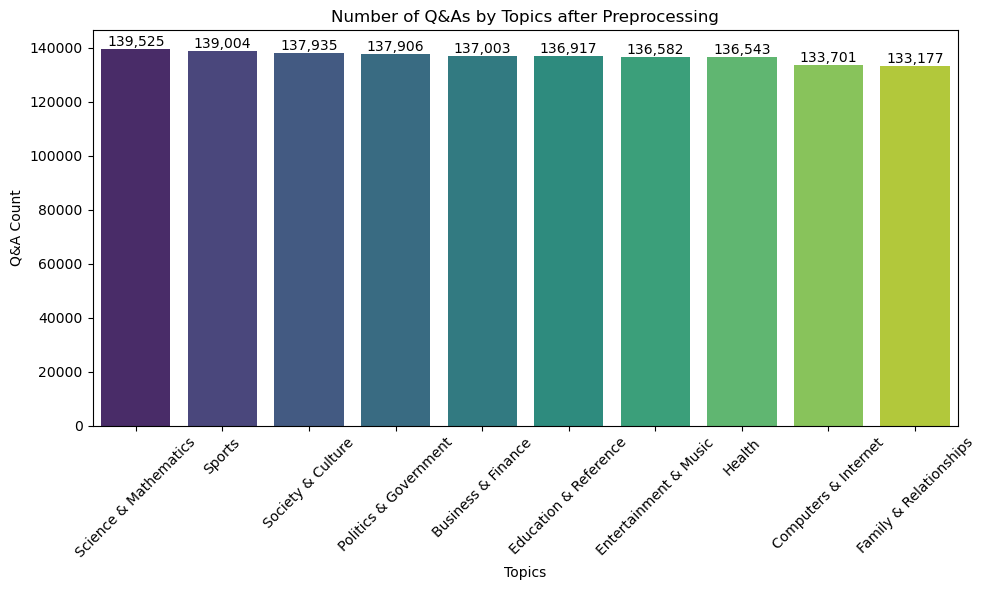

In [23]:
# Plot the total count of Q&As per topic
plt.figure(figsize=(10, 6))
sns.barplot(x='topic_name', y='count', hue='topic_name', data=topic_counts, palette='viridis')

plt.xlabel('Topics')
plt.ylabel('Q&A Count')
plt.title('Number of Q&As by Topics after Preprocessing')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(topic_counts['count']):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Train test split

In [24]:
X = train_clean_no_duplicates.drop(columns=['topic', 'topic_name'])
y = train_clean_no_duplicates['topic']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [25]:
len(X_train)

1094634

In [26]:
len(y_train)

1094634

In [27]:
len(X_val)

273659

In [28]:
len(y_val)

273659

In [29]:
X_train.head()

,best_answer,question
1170758,play simonsays command wipe nose,proper way let someone talking know booger han...
1238600,figos wife,sexiest wife footballer world cup 2006
707981,liverpool rules,curious ever read team history liverpools 3 tr...
207846,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...
1315775,looks like carolina hurricanes going win 31 se...,win stanley cup


In [30]:
X_val.head()

,best_answer,question
210868,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...
332397,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...
1287631,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...
590830,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...
255960,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling


### Fast Text Classification


In [36]:
train_combined = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_combined = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)], axis=1)


In [37]:
print(len(train_combined))
print(len(val_combined))

1094634
273659


In [38]:
train_combined['category'] = "__label__" + train_combined['topic'].astype(str)
val_combined['category'] = "__label__" + val_combined['topic'].astype(str)


#### FastText Classification using question

In [73]:
train_combined['category_question'] = train_combined['category'] + " " + train_combined['question']
train_combined

,best_answer,question,topic,category,category_question,category_best_answer,category_all
0,play simonsays command wipe nose,proper way let someone talking know booger han...,0,__label__0,__label__0 proper way let someone talking know...,__label__0 play simonsays command wipe nose,__label__0 proper way let someone talking know...
1,figos wife,sexiest wife footballer world cup 2006,5,__label__5,__label__5 sexiest wife footballer world cup 2...,__label__5 figos wife,__label__5 sexiest wife footballer world cup 2...
2,liverpool rules,curious ever read team history liverpools 3 tr...,5,__label__5,__label__5 curious ever read team history live...,__label__5 liverpool rules,__label__5 curious ever read team history live...
3,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...,9,__label__9,__label__9 illegitimate rule body help thanks ...,__label__9 believe illegitimate rule simply si...,__label__9 illegitimate rule body help thanks ...
4,looks like carolina hurricanes going win 31 se...,win stanley cup,5,__label__5,__label__5 win stanley cup,__label__5 looks like carolina hurricanes goin...,__label__5 win stanley cup looks like carolin...
...,...,...,...,...,...,...,...
1094629,rather yummy,alcohol,3,__label__3,__label__3 alcohol,__label__3 rather yummy,__label__3 alcohol rather yummy
1094630,progeria,disease age body doesntyou look 12 youre 35,1,__label__1,__label__1 disease age body doesntyou look 12 ...,__label__1 progeria,__label__1 disease age body doesntyou look 12 ...
1094631,thats called dignitymost politicians dont itsh...,kinky friedman candidate isnt bashing opponent...,9,__label__9,__label__9 kinky friedman candidate isnt bashi...,__label__9 thats called dignitymost politician...,__label__9 kinky friedman candidate isnt bashi...
1094632,course want rights straight people,think gays able serve armed forces,0,__label__0,__label__0 think gays able serve armed forces,__label__0 course want rights straight people,__label__0 think gays able serve armed forces ...


In [74]:
val_combined['category_question'] = val_combined['category'] + " " + val_combined['question']
val_combined

,best_answer,question,topic,category,category_question,category_best_answer,category_all
0,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...,5,__label__5,__label__5 want pictures ocean waves comes bea...,__label__5 heres one cartoon surfer hanging 10...,__label__5 want pictures ocean waves comes bea...
1,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...,0,__label__0,__label__0 turnquestions religious 1 would peo...,__label__0 1 ancient people technical knowledg...,__label__0 turnquestions religious 1 would peo...
2,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...,6,__label__6,__label__6 new villa development would buy ass...,__label__6 wow good question doubt oman united...,__label__6 new villa development would buy ass...
3,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...,4,__label__4,__label__4 information opencms get good inform...,__label__4 httpwwwopencmsorgopencmsen main sit...,__label__4 information opencms get good inform...
4,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling,5,__label__5,__label__5 clk320 engine ticking noise car idl...,__label__5 water pump fuel pump sometimes tick...,__label__5 clk320 engine ticking noise car idl...
...,...,...,...,...,...,...,...
273654,plot quadratic formula cartesian coordinate gi...,quadratic formula relates graph parabola,3,__label__3,__label__3 quadratic formula relates graph par...,__label__3 plot quadratic formula cartesian co...,__label__3 quadratic formula relates graph par...
273655,presume boyfriend age well sit doesnt communic...,weird things guys boyfriends seems ask many qu...,8,__label__8,__label__8 weird things guys boyfriends seems ...,__label__8 presume boyfriend age well sit does...,__label__8 weird things guys boyfriends seems ...
273656,assuming asking rods fully withdrawn answer si...,controll rods pulled nuclear power plant run m...,1,__label__1,__label__1 controll rods pulled nuclear power ...,__label__1 assuming asking rods fully withdraw...,__label__1 controll rods pulled nuclear power ...
273657,would want middle head kind mohawk would spray...,got 8 strands hair left would want 1 place wel...,2,__label__2,__label__2 got 8 strands hair left would want ...,__label__2 would want middle head kind mohawk ...,__label__2 got 8 strands hair left would want ...


In [75]:
# save train and validation into txt format
train_combined.to_csv("FastText_question.train",columns=["category_question"],index=False,header=False)
val_combined.to_csv("FastText_question.val",columns=["category_question"],index=False,header=False)


In [79]:
# train fasttext classification model
question_model = fasttext.train_supervised(input="FastText_question.train")
question_model.test("FastText_question.val")

Read 20M words
Number of words:  782272
Number of labels: 10
Progress: 100.0% words/sec/thread: 3640714 lr:  0.000000 avg.loss:  1.007856 ETA:   0h 0m 0s100.0% words/sec/thread: 3640770 lr: -0.000001 avg.loss:  1.007856 ETA:   0h 0m 0s


(273659, 0.7022973847013985, 0.7022973847013985)

In [81]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_question.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [question_model.predict(text)[0][0] for text in validation_data]

In [82]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.7022973847013985
Macro Precision: 0.6996110328865901
Macro Recall: 0.7026492321348312
Macro F1-score: 0.7004892552168219


In [83]:
# Define parameter options
parameter_options = {
    "epoch": [5, 10, 15],
    "lr": [0.1, 0.3, 0.5],
    "wordNgrams": [1, 2],
    "dim": [100, 200],
    "loss": ["softmax", "ova"]
}


In [84]:
# Generate all combinations of parameters
parameter_combinations = list(itertools.product(
    parameter_options["epoch"],
    parameter_options["lr"],
    parameter_options["wordNgrams"],
    parameter_options["dim"],
    parameter_options["loss"]
))

In [85]:
results = []

for params in parameter_combinations:
    epoch, lr, wordNgrams, dim, loss = params

    model = fasttext.train_supervised(
        input="FastText_all.train",
        epoch=epoch,
        lr=lr,
        wordNgrams=wordNgrams,
        dim=dim,
        loss=loss
    )

    # Predict on validation data
    predicted_labels = [model.predict(text)[0][0] for text in validation_data]

    # Compute metrics
    report = classification_report(true_labels, predicted_labels, output_dict=True)
    accuracy = report["accuracy"]
    macro_precision = report["macro avg"]["precision"]
    macro_recall = report["macro avg"]["recall"]
    macro_f1 = report["macro avg"]["f1-score"]

    # Store results
    results.append({
        "epoch": epoch,
        "lr": lr,
        "wordNgrams": wordNgrams,
        "dim": dim,
        "loss": loss,
        "accuracy": accuracy,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1
    })

    print(f"Completed combination: {params}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="macro_f1", ascending=False)

Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 4979250 lr:  0.000000 avg.loss:  0.955082 ETA:   0h 0m 0s


Completed combination: (5, 0.1, 1, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5193936 lr:  0.000000 avg.loss:  1.543353 ETA:   0h 0m 0s


Completed combination: (5, 0.1, 1, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3369364 lr:  0.000000 avg.loss:  0.954283 ETA:   0h 0m 0s


Completed combination: (5, 0.1, 1, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3503466 lr:  0.000000 avg.loss:  1.547202 ETA:   0h 0m 0s


Completed combination: (5, 0.1, 1, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2591212 lr:  0.000000 avg.loss:  0.602076 ETA:   0h 0m 0s


Completed combination: (5, 0.1, 2, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2543441 lr:  0.000000 avg.loss:  1.061956 ETA:   0h 0m 0s


Completed combination: (5, 0.1, 2, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1534687 lr:  0.000000 avg.loss:  0.610063 ETA:   0h 0m 0s


Completed combination: (5, 0.1, 2, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1503445 lr: -0.000000 avg.loss:  1.048203 ETA:   0h 0m 0s 0.000000 avg.loss:  1.048203 ETA:   0h 0m 0s


Completed combination: (5, 0.1, 2, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5294196 lr:  0.000000 avg.loss:  0.952380 ETA:   0h 0m 0s


Completed combination: (5, 0.3, 1, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5190351 lr:  0.000000 avg.loss:  1.544309 ETA:   0h 0m 0s


Completed combination: (5, 0.3, 1, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3609071 lr:  0.000000 avg.loss:  0.956892 ETA:   0h 0m 0s


Completed combination: (5, 0.3, 1, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3411235 lr:  0.000000 avg.loss:  1.545150 ETA:   0h 0m 0s


Completed combination: (5, 0.3, 1, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2668848 lr:  0.000000 avg.loss:  0.543877 ETA:   0h 0m 0s


Completed combination: (5, 0.3, 2, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2707489 lr:  0.000000 avg.loss:  0.957550 ETA:   0h 0m 0s


Completed combination: (5, 0.3, 2, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1629403 lr:  0.000000 avg.loss:  0.544661 ETA:   0h 0m 0s


Completed combination: (5, 0.3, 2, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1381517 lr:  0.000000 avg.loss:  0.959633 ETA:   0h 0m 0s


Completed combination: (5, 0.3, 2, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5339425 lr:  0.000000 avg.loss:  0.972336 ETA:   0h 0m 0s


Completed combination: (5, 0.5, 1, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5340127 lr:  0.000000 avg.loss:  1.562989 ETA:   0h 0m 0s


Completed combination: (5, 0.5, 1, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3653067 lr:  0.000000 avg.loss:  0.974352 ETA:   0h 0m 0s


Completed combination: (5, 0.5, 1, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3570792 lr:  0.000000 avg.loss:  1.564627 ETA:   0h 0m 0s


Completed combination: (5, 0.5, 1, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2731512 lr:  0.000000 avg.loss:  0.537731 ETA:   0h 0m 0s


Completed combination: (5, 0.5, 2, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2711862 lr:  0.000000 avg.loss:  0.957687 ETA:   0h 0m 0s


Completed combination: (5, 0.5, 2, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1680266 lr:  0.000000 avg.loss:  0.541587 ETA:   0h 0m 0s


Completed combination: (5, 0.5, 2, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1504917 lr:  0.000000 avg.loss:  0.955701 ETA:   0h 0m 0s


Completed combination: (5, 0.5, 2, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5342726 lr:  0.000000 avg.loss:  0.866965 ETA:   0h 0m 0s


Completed combination: (10, 0.1, 1, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5210766 lr:  0.000000 avg.loss:  1.429389 ETA:   0h 0m 0s


Completed combination: (10, 0.1, 1, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3593417 lr:  0.000000 avg.loss:  0.864553 ETA:   0h 0m 0s


Completed combination: (10, 0.1, 1, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3458106 lr:  0.000000 avg.loss:  1.431237 ETA:   0h 0m 0s


Completed combination: (10, 0.1, 1, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2409326 lr:  0.000000 avg.loss:  0.333102 ETA:   0h 0m 0s


Completed combination: (10, 0.1, 2, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2544194 lr:  0.000000 avg.loss:  0.604930 ETA:   0h 0m 0s


Completed combination: (10, 0.1, 2, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1658848 lr:  0.000000 avg.loss:  0.330557 ETA:   0h 0m 0s


Completed combination: (10, 0.1, 2, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1515859 lr:  0.000000 avg.loss:  0.603014 ETA:   0h 0m 0s100.0% words/sec/thread: 1515866 lr: -0.000000 avg.loss:  0.603014 ETA:   0h 0m 0s


Completed combination: (10, 0.1, 2, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5399134 lr:  0.000000 avg.loss:  0.867868 ETA:   0h 0m 0s


Completed combination: (10, 0.3, 1, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5312074 lr:  0.000000 avg.loss:  1.417799 ETA:   0h 0m 0s


Completed combination: (10, 0.3, 1, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3691848 lr:  0.000000 avg.loss:  0.882573 ETA:   0h 0m 0s


Completed combination: (10, 0.3, 1, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3633008 lr:  0.000000 avg.loss:  1.409621 ETA:   0h 0m 0s


Completed combination: (10, 0.3, 1, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2738048 lr:  0.000000 avg.loss:  0.319446 ETA:   0h 0m 0s


Completed combination: (10, 0.3, 2, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2740165 lr:  0.000000 avg.loss:  0.579957 ETA:   0h 0m 0s


Completed combination: (10, 0.3, 2, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1661465 lr:  0.000000 avg.loss:  0.316561 ETA:   0h 0m 0s


Completed combination: (10, 0.3, 2, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1447647 lr:  0.000000 avg.loss:  0.575951 ETA:   0h 0m 0s 0m 0s


Completed combination: (10, 0.3, 2, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5265804 lr:  0.000000 avg.loss:  0.885086 ETA:   0h 0m 0s


Completed combination: (10, 0.5, 1, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5256188 lr:  0.000000 avg.loss:  1.440620 ETA:   0h 0m 0s


Completed combination: (10, 0.5, 1, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3664929 lr:  0.000000 avg.loss:  0.865760 ETA:   0h 0m 0s


Completed combination: (10, 0.5, 1, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3640080 lr:  0.000000 avg.loss:  1.470099 ETA:   0h 0m 0s


Completed combination: (10, 0.5, 1, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2734681 lr:  0.000000 avg.loss:  0.327363 ETA:   0h 0m 0s


Completed combination: (10, 0.5, 2, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2714547 lr:  0.000000 avg.loss:  0.586021 ETA:   0h 0m 0s


Completed combination: (10, 0.5, 2, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1687589 lr:  0.000000 avg.loss:  0.318248 ETA:   0h 0m 0s


Completed combination: (10, 0.5, 2, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1651725 lr:  0.000000 avg.loss:  0.581510 ETA:   0h 0m 0s


Completed combination: (10, 0.5, 2, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5333695 lr:  0.000000 avg.loss:  0.807081 ETA:   0h 0m 0s


Completed combination: (15, 0.1, 1, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5328384 lr:  0.000000 avg.loss:  1.347257 ETA:   0h 0m 0s


Completed combination: (15, 0.1, 1, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3696612 lr:  0.000000 avg.loss:  0.804075 ETA:   0h 0m 0s


Completed combination: (15, 0.1, 1, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3653784 lr:  0.000000 avg.loss:  1.350012 ETA:   0h 0m 0s


Completed combination: (15, 0.1, 1, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2760484 lr:  0.000000 avg.loss:  0.234056 ETA:   0h 0m 0s


Completed combination: (15, 0.1, 2, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2718734 lr:  0.000000 avg.loss:  0.424206 ETA:   0h 0m 0s


Completed combination: (15, 0.1, 2, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1694112 lr:  0.000000 avg.loss:  0.229339 ETA:   0h 0m 0s


Completed combination: (15, 0.1, 2, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1665702 lr:  0.000000 avg.loss:  0.420724 ETA:   0h 0m 0s 0.420724 ETA:   0h 0m 0s


Completed combination: (15, 0.1, 2, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5366928 lr:  0.000000 avg.loss:  0.781231 ETA:   0h 0m 0s


Completed combination: (15, 0.3, 1, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5305793 lr:  0.000000 avg.loss:  1.377135 ETA:   0h 0m 0s


Completed combination: (15, 0.3, 1, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3398155 lr:  0.000000 avg.loss:  0.748435 ETA:   0h 0m 0s


Completed combination: (15, 0.3, 1, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3622427 lr:  0.000000 avg.loss:  1.336910 ETA:   0h 0m 0s


Completed combination: (15, 0.3, 1, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2742393 lr:  0.000000 avg.loss:  0.229910 ETA:   0h 0m 0s


Completed combination: (15, 0.3, 2, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2702094 lr:  0.000000 avg.loss:  0.418045 ETA:   0h 0m 0s


Completed combination: (15, 0.3, 2, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1682988 lr:  0.000000 avg.loss:  0.228562 ETA:   0h 0m 0s


Completed combination: (15, 0.3, 2, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1606908 lr:  0.000000 avg.loss:  0.420709 ETA:   0h 0m 0s


Completed combination: (15, 0.3, 2, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5350109 lr:  0.000000 avg.loss:  0.805651 ETA:   0h 0m 0s0s


Completed combination: (15, 0.5, 1, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 5302758 lr:  0.000000 avg.loss:  1.326620 ETA:   0h 0m 0s


Completed combination: (15, 0.5, 1, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3675375 lr:  0.000000 avg.loss:  0.796543 ETA:   0h 0m 0s


Completed combination: (15, 0.5, 1, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 3641098 lr:  0.000000 avg.loss:  1.371499 ETA:   0h 0m 0s


Completed combination: (15, 0.5, 1, 200, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2723860 lr:  0.000000 avg.loss:  0.240062 ETA:   0h 0m 0s


Completed combination: (15, 0.5, 2, 100, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 2745766 lr:  0.000000 avg.loss:  0.424309 ETA:   0h 0m 0s


Completed combination: (15, 0.5, 2, 100, 'ova')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1676939 lr:  0.000000 avg.loss:  0.230468 ETA:   0h 0m 0s


Completed combination: (15, 0.5, 2, 200, 'softmax')


Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 1538487 lr:  0.000000 avg.loss:  0.422694 ETA:   0h 0m 0s1241406 lr:  0.478306 avg.loss:  1.852781 ETA:   0h 1m30s


Completed combination: (15, 0.5, 2, 200, 'ova')


In [86]:
results_df

,epoch,lr,wordNgrams,dim,loss,accuracy,macro_precision,macro_recall,macro_f1
3,5,0.1,1,200,ova,0.690045,0.696296,0.690487,0.691943
1,5,0.1,1,100,ova,0.689727,0.696118,0.690183,0.691590
9,5,0.3,1,100,ova,0.687355,0.694221,0.687800,0.689536
11,5,0.3,1,200,ova,0.687476,0.693670,0.687933,0.689247
17,5,0.5,1,100,ova,0.684399,0.690160,0.684851,0.686273
...,...,...,...,...,...,...,...,...,...
63,15,0.3,2,200,ova,0.607289,0.646271,0.608029,0.615343
47,10,0.5,2,200,ova,0.607932,0.642812,0.608624,0.614957
45,10,0.5,2,100,ova,0.607840,0.642794,0.608555,0.614663
69,15,0.5,2,100,ova,0.600463,0.646560,0.601245,0.610133


#### FastText Classification using best_answer

In [59]:
train_combined['category_best_answer'] = train_combined['category'] + " " + train_combined['best_answer']
train_combined

,best_answer,question,topic,category,category_question,category_best_answer
0,play simonsays command wipe nose,proper way let someone talking know booger han...,0,__label__0,__label__0 proper way let someone talking know...,__label__0 play simonsays command wipe nose
1,figos wife,sexiest wife footballer world cup 2006,5,__label__5,__label__5 sexiest wife footballer world cup 2...,__label__5 figos wife
2,liverpool rules,curious ever read team history liverpools 3 tr...,5,__label__5,__label__5 curious ever read team history live...,__label__5 liverpool rules
3,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...,9,__label__9,__label__9 illegitimate rule body help thanks ...,__label__9 believe illegitimate rule simply si...
4,looks like carolina hurricanes going win 31 se...,win stanley cup,5,__label__5,__label__5 win stanley cup,__label__5 looks like carolina hurricanes goin...
...,...,...,...,...,...,...
1094629,rather yummy,alcohol,3,__label__3,__label__3 alcohol,__label__3 rather yummy
1094630,progeria,disease age body doesntyou look 12 youre 35,1,__label__1,__label__1 disease age body doesntyou look 12 ...,__label__1 progeria
1094631,thats called dignitymost politicians dont itsh...,kinky friedman candidate isnt bashing opponent...,9,__label__9,__label__9 kinky friedman candidate isnt bashi...,__label__9 thats called dignitymost politician...
1094632,course want rights straight people,think gays able serve armed forces,0,__label__0,__label__0 think gays able serve armed forces,__label__0 course want rights straight people


In [60]:
val_combined['category_best_answer'] = val_combined['category'] + " " + val_combined['best_answer']
val_combined

,best_answer,question,topic,category,category_question,category_best_answer
0,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...,5,__label__5,__label__5 want pictures ocean waves comes bea...,__label__5 heres one cartoon surfer hanging 10...
1,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...,0,__label__0,__label__0 turnquestions religious 1 would peo...,__label__0 1 ancient people technical knowledg...
2,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...,6,__label__6,__label__6 new villa development would buy ass...,__label__6 wow good question doubt oman united...
3,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...,4,__label__4,__label__4 information opencms get good inform...,__label__4 httpwwwopencmsorgopencmsen main sit...
4,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling,5,__label__5,__label__5 clk320 engine ticking noise car idl...,__label__5 water pump fuel pump sometimes tick...
...,...,...,...,...,...,...
273654,plot quadratic formula cartesian coordinate gi...,quadratic formula relates graph parabola,3,__label__3,__label__3 quadratic formula relates graph par...,__label__3 plot quadratic formula cartesian co...
273655,presume boyfriend age well sit doesnt communic...,weird things guys boyfriends seems ask many qu...,8,__label__8,__label__8 weird things guys boyfriends seems ...,__label__8 presume boyfriend age well sit does...
273656,assuming asking rods fully withdrawn answer si...,controll rods pulled nuclear power plant run m...,1,__label__1,__label__1 controll rods pulled nuclear power ...,__label__1 assuming asking rods fully withdraw...
273657,would want middle head kind mohawk would spray...,got 8 strands hair left would want 1 place wel...,2,__label__2,__label__2 got 8 strands hair left would want ...,__label__2 would want middle head kind mohawk ...


In [61]:
# save train and validation into txt format
train_combined.to_csv("FastText_best_answer.train",columns=["category_best_answer"],index=False,header=False)
val_combined.to_csv("FastText_best_answer.val",columns=["category_best_answer"],index=False,header=False)


In [62]:
# train fasttext classification model
best_answer_model = fasttext.train_supervised(input="FastText_best_answer.train")
best_answer_model.test("FastText_best_answer.val")

Read 37M words
Number of words:  1698041
Number of labels: 10
Progress: 100.0% words/sec/thread: 4733069 lr:  0.000000 avg.loss:  1.323982 ETA:   0h 0m 0s


(273659, 0.5991580762920277, 0.5991580762920277)

In [64]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_best_answer.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [best_answer_model.predict(text)[0][0] for text in validation_data]

In [65]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.5991580762920277
Macro Precision: 0.5980962538508586
Macro Recall: 0.5995273428919461
Macro F1-score: 0.5974362340974888


#### FastText Classification using best_answer and question

In [66]:
train_combined['category_all'] = train_combined['category'] + " " + train_combined['question'] + " " + train_combined['best_answer']
train_combined

,best_answer,question,topic,category,category_question,category_best_answer,category_all
0,play simonsays command wipe nose,proper way let someone talking know booger han...,0,__label__0,__label__0 proper way let someone talking know...,__label__0 play simonsays command wipe nose,__label__0 proper way let someone talking know...
1,figos wife,sexiest wife footballer world cup 2006,5,__label__5,__label__5 sexiest wife footballer world cup 2...,__label__5 figos wife,__label__5 sexiest wife footballer world cup 2...
2,liverpool rules,curious ever read team history liverpools 3 tr...,5,__label__5,__label__5 curious ever read team history live...,__label__5 liverpool rules,__label__5 curious ever read team history live...
3,believe illegitimate rule simply situation cou...,illegitimate rule body help thanks new zealand...,9,__label__9,__label__9 illegitimate rule body help thanks ...,__label__9 believe illegitimate rule simply si...,__label__9 illegitimate rule body help thanks ...
4,looks like carolina hurricanes going win 31 se...,win stanley cup,5,__label__5,__label__5 win stanley cup,__label__5 looks like carolina hurricanes goin...,__label__5 win stanley cup looks like carolin...
...,...,...,...,...,...,...,...
1094629,rather yummy,alcohol,3,__label__3,__label__3 alcohol,__label__3 rather yummy,__label__3 alcohol rather yummy
1094630,progeria,disease age body doesntyou look 12 youre 35,1,__label__1,__label__1 disease age body doesntyou look 12 ...,__label__1 progeria,__label__1 disease age body doesntyou look 12 ...
1094631,thats called dignitymost politicians dont itsh...,kinky friedman candidate isnt bashing opponent...,9,__label__9,__label__9 kinky friedman candidate isnt bashi...,__label__9 thats called dignitymost politician...,__label__9 kinky friedman candidate isnt bashi...
1094632,course want rights straight people,think gays able serve armed forces,0,__label__0,__label__0 think gays able serve armed forces,__label__0 course want rights straight people,__label__0 think gays able serve armed forces ...


In [67]:
val_combined['category_all'] = val_combined['category'] + " " + val_combined['question'] + " " + val_combined['best_answer']

val_combined

,best_answer,question,topic,category,category_question,category_best_answer,category_all
0,heres one cartoon surfer hanging 10nhttpwwwedh...,want pictures ocean waves comes beaches surfer...,5,__label__5,__label__5 want pictures ocean waves comes bea...,__label__5 heres one cartoon surfer hanging 10...,__label__5 want pictures ocean waves comes bea...
1,1 ancient people technical knowledge thing wou...,turnquestions religious 1 would people two tho...,0,__label__0,__label__0 turnquestions religious 1 would peo...,__label__0 1 ancient people technical knowledg...,__label__0 turnquestions religious 1 would peo...
2,wow good question doubt oman united arab emira...,new villa development would buy assuming affor...,6,__label__6,__label__6 new villa development would buy ass...,__label__6 wow good question doubt oman united...,__label__6 new villa development would buy ass...
3,httpwwwopencmsorgopencmsen main sitennhttpwwwo...,information opencms get good information worki...,4,__label__4,__label__4 information opencms get good inform...,__label__4 httpwwwopencmsorgopencmsen main sit...,__label__4 information opencms get good inform...
4,water pump fuel pump sometimes ticking sound i...,clk320 engine ticking noise car idling,5,__label__5,__label__5 clk320 engine ticking noise car idl...,__label__5 water pump fuel pump sometimes tick...,__label__5 clk320 engine ticking noise car idl...
...,...,...,...,...,...,...,...
273654,plot quadratic formula cartesian coordinate gi...,quadratic formula relates graph parabola,3,__label__3,__label__3 quadratic formula relates graph par...,__label__3 plot quadratic formula cartesian co...,__label__3 quadratic formula relates graph par...
273655,presume boyfriend age well sit doesnt communic...,weird things guys boyfriends seems ask many qu...,8,__label__8,__label__8 weird things guys boyfriends seems ...,__label__8 presume boyfriend age well sit does...,__label__8 weird things guys boyfriends seems ...
273656,assuming asking rods fully withdrawn answer si...,controll rods pulled nuclear power plant run m...,1,__label__1,__label__1 controll rods pulled nuclear power ...,__label__1 assuming asking rods fully withdraw...,__label__1 controll rods pulled nuclear power ...
273657,would want middle head kind mohawk would spray...,got 8 strands hair left would want 1 place wel...,2,__label__2,__label__2 got 8 strands hair left would want ...,__label__2 would want middle head kind mohawk ...,__label__2 got 8 strands hair left would want ...


In [68]:
# save train and validation into txt format
train_combined.to_csv("FastText_all.train",columns=["category_all"],index=False,header=False)
val_combined.to_csv("FastText_all.val",columns=["category_all"],index=False,header=False)


In [69]:
# train fasttext classification model
best_answer_model = fasttext.train_supervised(input="FastText_all.train")
best_answer_model.test("FastText_all.val")

Read 54M words
Number of words:  2203280
Number of labels: 10
Progress: 100.0% words/sec/thread: 4885595 lr:  0.000000 avg.loss:  0.953532 ETA:   0h 0m 0s


(273659, 0.7141186659309579, 0.7141186659309579)

In [70]:
# Prepare validation dataset
validation_data = []
true_labels = []
with open("FastText_all.val", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        true_labels.append(parts[0])  
        validation_data.append(parts[1]) 

# Predict using the model
predicted_labels = [best_answer_model.predict(text)[0][0] for text in validation_data]

In [71]:
# Generate the classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)

# Extract specific metrics
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1-score: {macro_f1}")

Accuracy: 0.7141186659309579
Macro Precision: 0.7107342769811893
Macro Recall: 0.714395188788769
Macro F1-score: 0.7118708680361945
